In [281]:
%load_ext autoreload
%autoreload 2
import glob
import json
import numpy as np
import pandas as pd
import import_lakes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
df_g = import_lakes.import_lake_greifen()
df_g['day'] = df_g['date'].apply(lambda x : x.replace(hour=0,minute=0,second=0,microsecond=0))
df_g_day = df_g.groupby('day').mean()
df_g_day.reset_index(inplace=True)

In [3]:
import matplotlib.pyplot as plt

In [4]:
df['x'].values[0] / 60 /60 - df['x'].values[8] / 60 /60

-23.608888888848014

# chunk data into days

In [4]:
day_df = pd.DataFrame([df.to_numpy()[i*8:(i+1)*8].mean(axis=0) for i in range(len(df)//8)],columns=df.columns)

In [5]:
day_df

,x,z,z1,z2,z3,z4,z5,z6,z7,z8,z9
0,1.593633e+09,9.914375,0.368563,0.250000,70.923749,7.37500,7.953188,14.26250,-0.25000,3.46875,-0.36875
1,1.593719e+09,10.816688,0.376937,0.249563,90.485001,9.22500,8.042875,13.77500,-0.11875,3.69375,0.29375
2,1.593805e+09,10.702438,0.376812,0.249875,79.800000,8.34375,7.987875,11.38125,-0.13750,3.77500,-1.81875
3,1.593892e+09,10.936375,0.378625,0.250000,82.480000,8.55000,8.012750,10.71875,0.00000,3.83125,-1.71250
4,1.593978e+09,10.504125,0.374938,0.249875,79.435624,8.32500,7.973062,10.49375,-0.04375,3.41250,0.51875
...,...,...,...,...,...,...,...,...,...,...,...
791,1.681658e+09,7.729063,339.412498,463.231247,102.089374,9.02500,10.119812,15.81250,1.80000,2.90000,-3.05625
792,1.681831e+09,7.400437,336.993752,463.937496,96.271875,8.71250,10.044563,12.76875,1.86250,2.25625,-3.07500
793,1.682003e+09,7.876125,342.250000,464.543743,95.108749,8.51875,10.219688,15.11875,2.23750,2.82500,-3.25000
794,1.682176e+09,7.771437,341.250000,464.724998,94.716874,8.37500,10.324188,13.72500,2.35000,2.60625,-1.57500


In [6]:
day_df['x'].values[0] / 60 /60 - day_df['x'].values[1] / 60 /60

-23.95111111109145

### Remove Nones

In [286]:
df_g_day['z6'] = np.maximum(df_g_day['z6'],3)

### Ploting style

In [287]:
def initialize_plt(figsize = (6,6),fontsize = 22):
    # initialice Matplotlib
    _=plt.figure()
    plt.rcParams["figure.figsize"] = figsize
    plt.rcParams.update({'font.size': fontsize})
    plt.rcParams.update({'font.family':'Sans'})
    plt.rcParams.update({'lines.linewidth' : 3})
initialize_plt((10,7))

<Figure size 1000x700 with 0 Axes>

### Gaussian Filter

In [288]:
from scipy.ndimage import gaussian_filter1d

In [289]:
day_df = df_g_day

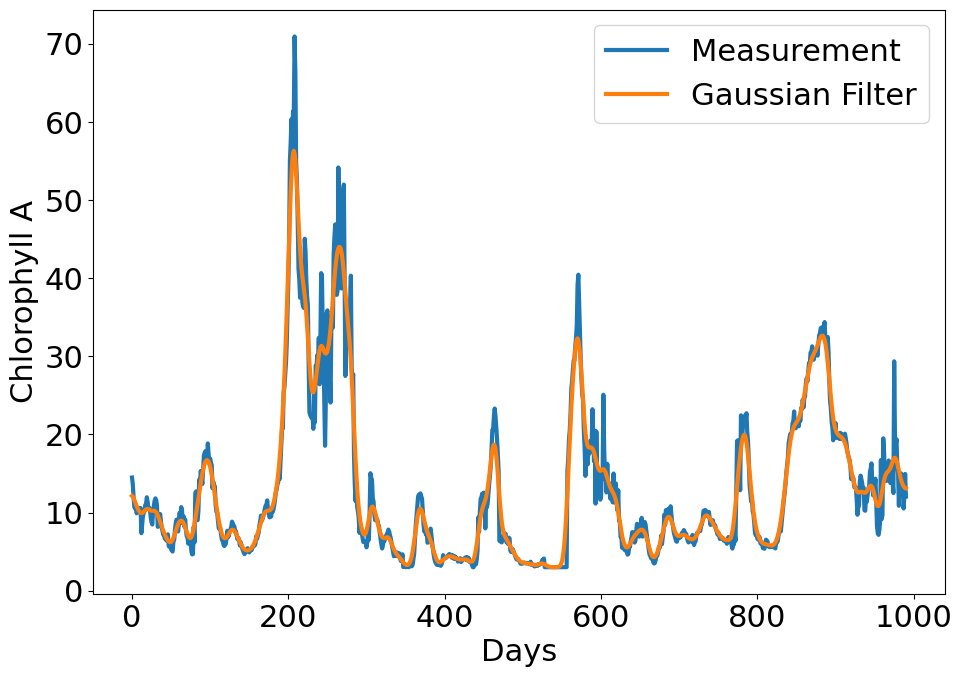

In [312]:
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
ax.plot(day_df['z6'].values,label='Measurement')
ax.plot(gaussian_filter1d(day_df['z6'].values,4),label='Gaussian Filter')
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.legend()
fig.savefig('Plots/ChlorophyllApGauss.png')

#### Train test split

In [313]:
ax.fill_between(range(600,1000),0,50, alpha=0.5,color='grey')
fig.savefig('Plots/ChlorophyllApGausstraintest.png')

### Example training evaluation

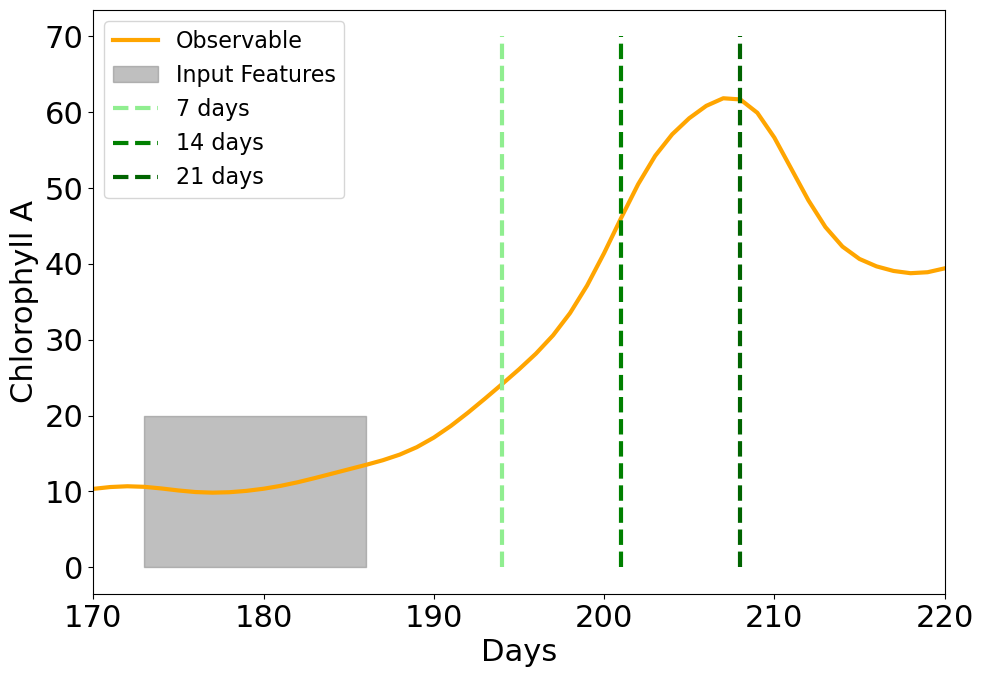

In [427]:
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_xlim([170,220])
s=173
ax.fill_between(range(s,s+14),0,20, alpha=0.5,color='grey',label='Input Features')
ax.vlines(s+21,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
ax.vlines(s+28,0,70,linestyles='dashed',colors = 'green',label='14 days')
ax.vlines(s+35,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/TrainTestExample.png')

## Create Training Data predict directly

In [306]:
from NN import LSTM_model
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset 

In [307]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps, len(chloro)-6):
    X.append(chloro[i-n_steps:i])
    Y.append(chloro[i+6])
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

## Define LSTM model to predict algea consentration of t+1 based on concentration at t

In [308]:
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [309]:
model_1 = LSTM_model(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)

In [310]:
model_1.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
for i in range(250):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_1(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))

313.5498141981151
271.8688002285892
235.3938125812844
220.13950344634384
212.1556040685471
199.6424752849422
193.67575534402508
194.27148065175095
184.38099661265335
182.3664101182598
176.48801522058983
173.1246703030312
171.48881127083138
168.91855212433697
167.9828246913544
162.56987958411648
160.4597827571712
161.93314484374164
157.55914147259438
155.2529909055527
153.69089596892056
152.423349315173
151.18489126963158
150.2765632786163
149.99854953974895
150.0293056017732
149.16019188867855
147.29622887911862
146.64516869636432
145.98257143203526
146.93419338905647
145.845982669151
146.86996073265598
145.63320393758278
143.40331511301537
143.22124084054607
142.85906039198784
142.8204818359793
143.96783590969974
142.49701463359676
142.81936235297215
142.1918444698804
142.15168318029953
142.0970113571376
141.80816268920898
141.74878700465374
142.04555845913822
141.56215330672592
142.4915198495943
141.83981302339737
142.0616005414153
141.61416589397274
143.09675773202557
141.5137572615

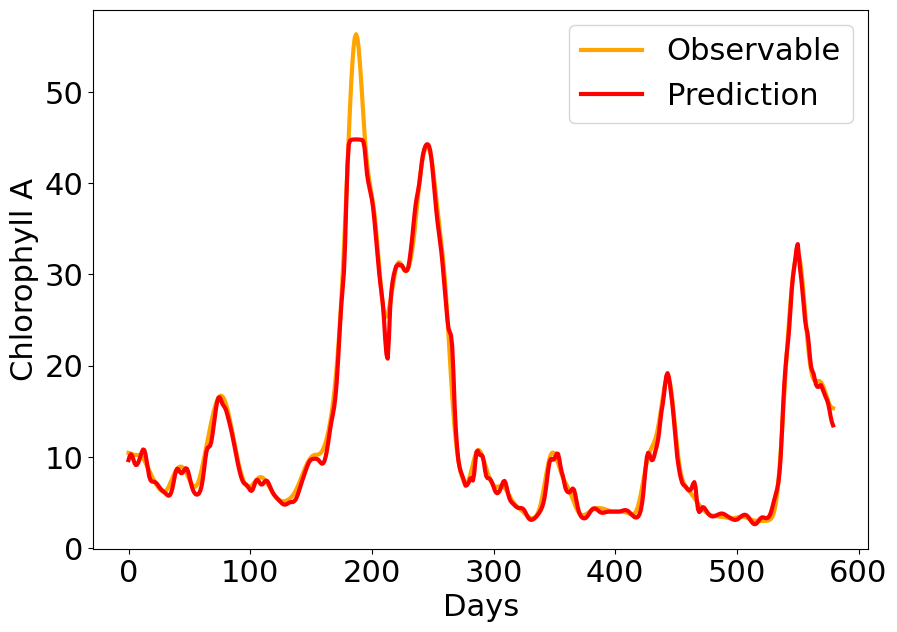

In [315]:
out, _ = model_1(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()

fig.savefig('Plots/Abstrain.png')


In [428]:
chloro = gaussian_filter1d(day_df['z6'].values,2)[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps, len(chloro)-6):
    X.append(chloro[i-n_steps:i])
    Y.append(chloro[i+6])
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

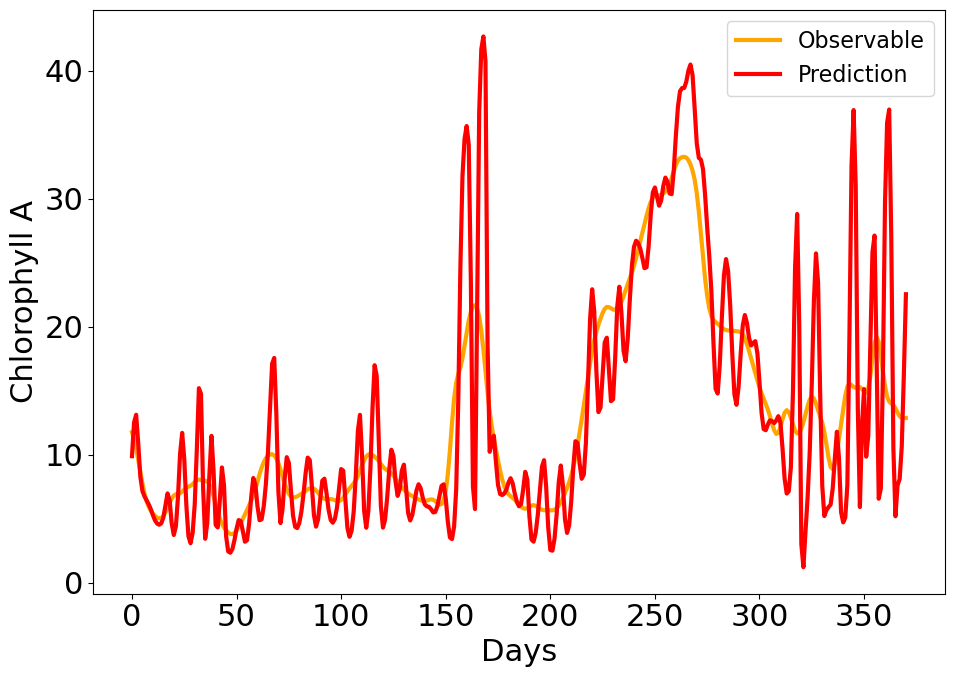

In [317]:
out, _ = model_1(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
# ax.set_xlim([130,180])
# ax.fill_between(range(139,153),0,15, alpha=0.5,color='grey',label='Input Features')
# ax.vlines(160,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Abstest.png')
#fig.savefig('TrainTestExample.png')

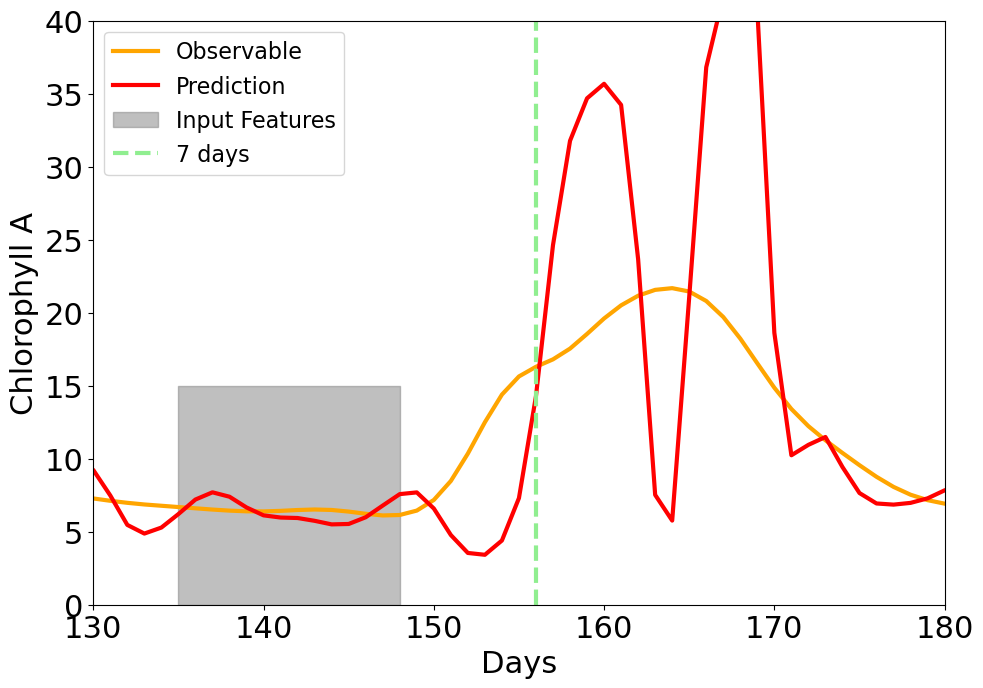

In [429]:
out, _ = model_1(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_xlim([130,180])
ax.set_ylim([0,40])
s = 135
ax.fill_between(range(s,s+14),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(s+21,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Abstest7.png')
#fig.savefig('TrainTestExample.png')

# Change and study the relative change

In [131]:
[np.maximum(np.minimum((chloro[i-n_steps:i] - chloro[i-1-n_steps:i-1]) / chloro[i-1-n_steps:i-1],2),-2) for i in range(n_steps+1, len(chloro))]

[array([ 0.00304011, -0.00688945, -0.01750497, -0.02579538, -0.02837572,
        -0.02355719, -0.01367858, -0.00433828,  0.00011485, -0.00061739,
        -0.00450089, -0.00869563, -0.00877509, -0.00041611]),
 array([-0.00688945, -0.01750497, -0.02579538, -0.02837572, -0.02355719,
        -0.01367858, -0.00433828,  0.00011485, -0.00061739, -0.00450089,
        -0.00869563, -0.00877509, -0.00041611,  0.01529427]),
 array([-0.01750497, -0.02579538, -0.02837572, -0.02355719, -0.01367858,
        -0.00433828,  0.00011485, -0.00061739, -0.00450089, -0.00869563,
        -0.00877509, -0.00041611,  0.01529427,  0.03041222]),
 array([-0.02579538, -0.02837572, -0.02355719, -0.01367858, -0.00433828,
         0.00011485, -0.00061739, -0.00450089, -0.00869563, -0.00877509,
        -0.00041611,  0.01529427,  0.03041222,  0.03714092]),
 array([-0.02837572, -0.02355719, -0.01367858, -0.00433828,  0.00011485,
        -0.00061739, -0.00450089, -0.00869563, -0.00877509, -0.00041611,
         0.01529427,  

In [325]:
from NN import LSTM_model_sig

In [333]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-6):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps:i])
    Y.append((chloro[i+6] / chloro[i-1] ))
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [337]:
model_2 = LSTM_model_sig(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [338]:
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [339]:
model_2.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1**(1/500))
for i in range(500):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_2(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))

0.2570129995272584
0.14964225107472237
0.13289670840109866
0.13079623056397047
0.13707493820980396
0.13108281574326835
0.12954904184970137
0.15164647669824835
0.12069843941661593
0.1230471664274188
0.11175826157455983
0.12768610577060752
0.11544981651161224
0.13779367461851608
0.13132940577215527
0.12711556243059569
0.1186648600109636
0.11370334228220051
0.13194513272443045
0.15022868701346118
0.12734966380649235
0.12755588119313732
0.10281280860662052
0.13541194704705722
0.10092746937162664
0.11208720153121099
0.13499934185449391
0.11949806910467474
0.09912625003657112
0.11607321055784617
0.12707779061508506
0.10211922241094178
0.12433946924921993
0.10572241852697853
0.11749988909147374
0.10099900120945826
0.0912129502386263
0.12921735034515597
0.11528898221887138
0.09566251252305834
0.11650318236485736
0.12540517759522143
0.10149350451075867
0.10528954159315318
0.10293730299868813
0.09302173261466908
0.10174857622191105
0.1045134616632984
0.1128572765737772
0.1047272138450652
0.09267

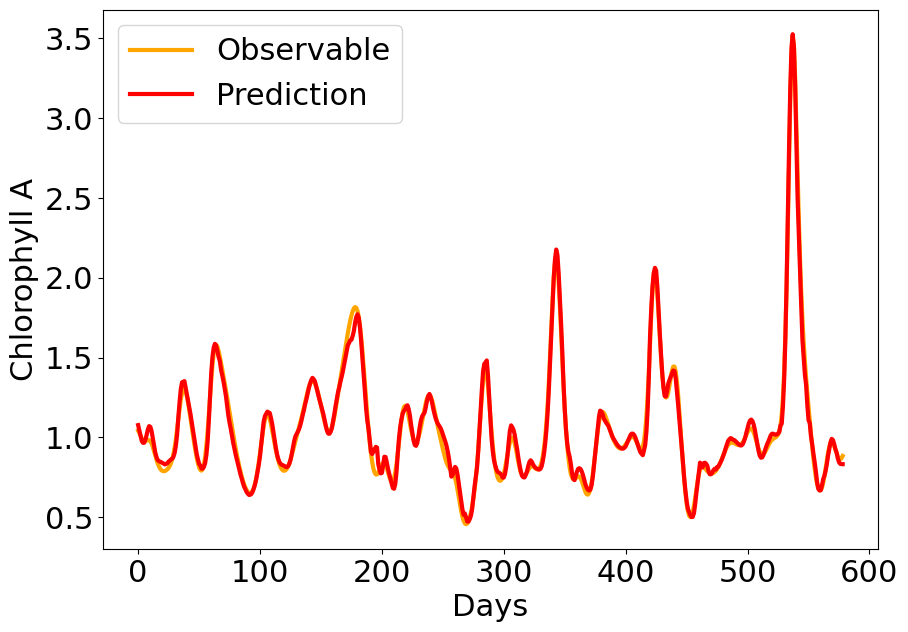

In [340]:
out, _ = model_2(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()
fig.savefig('Plots/reltrain7.png')


In [341]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[600:]
n_steps = 14
X, Y, Abs = [], [], []
for i in range(n_steps+1, len(chloro)-6):
    X.append( chloro[i-n_steps:i])
    Y.append((chloro[i+6] / chloro[i-1] ))
    Abs.append(chloro[i-1])

Abs_test = torch.tensor(np.array(Abs), dtype=torch.float32,device='cuda')

X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test= torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

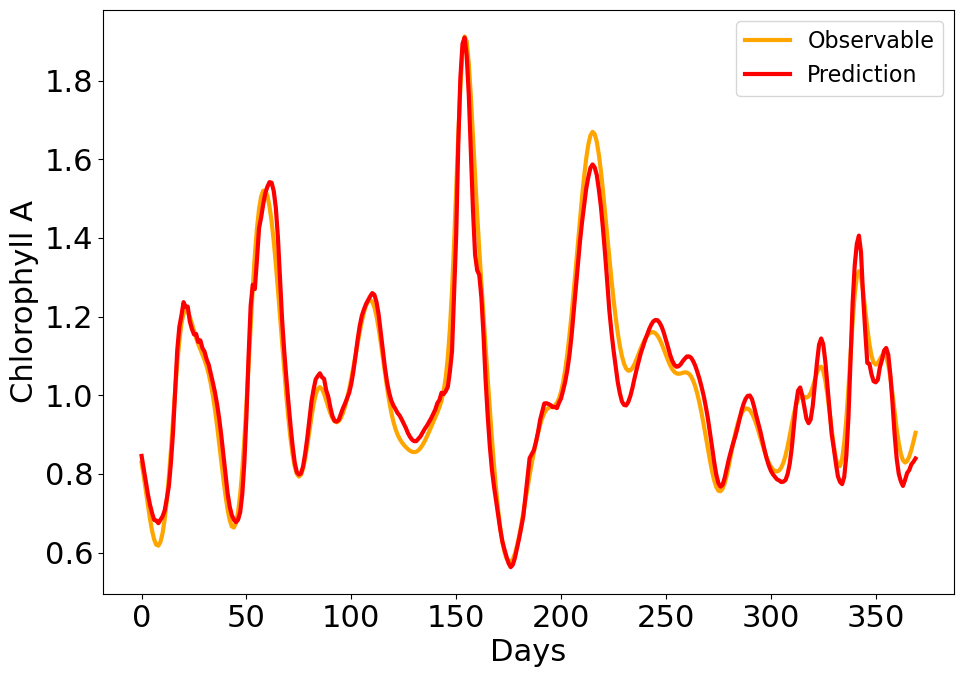

In [344]:
out, _ = model_2(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
# ax.set_xlim([130,180])
# ax.fill_between(range(139,153),0,15, alpha=0.5,color='grey',label='Input Features')
# ax.vlines(160,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest7.png')

#fig.savefig('TrainTestExample.png')

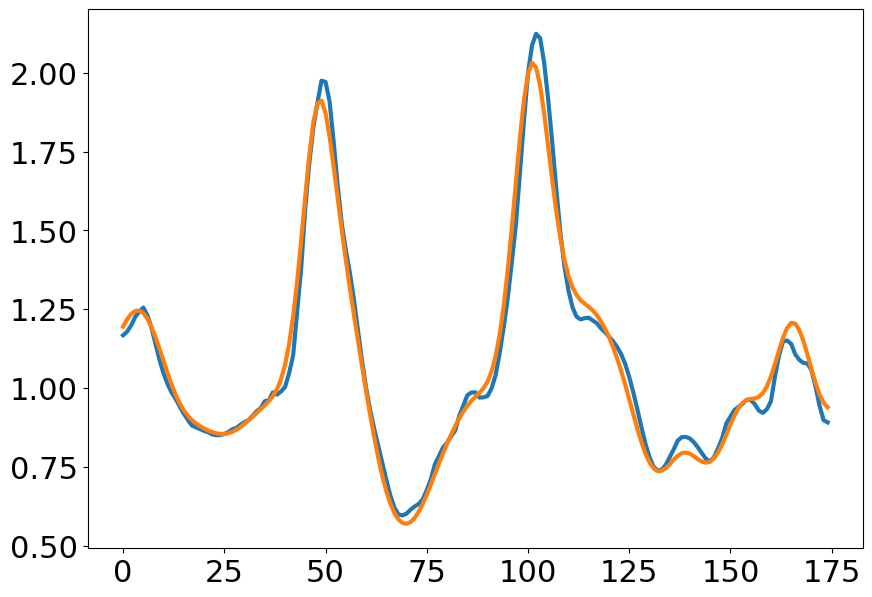

In [260]:
plt.plot(out.tolist())
plt.plot(Y_test.tolist())

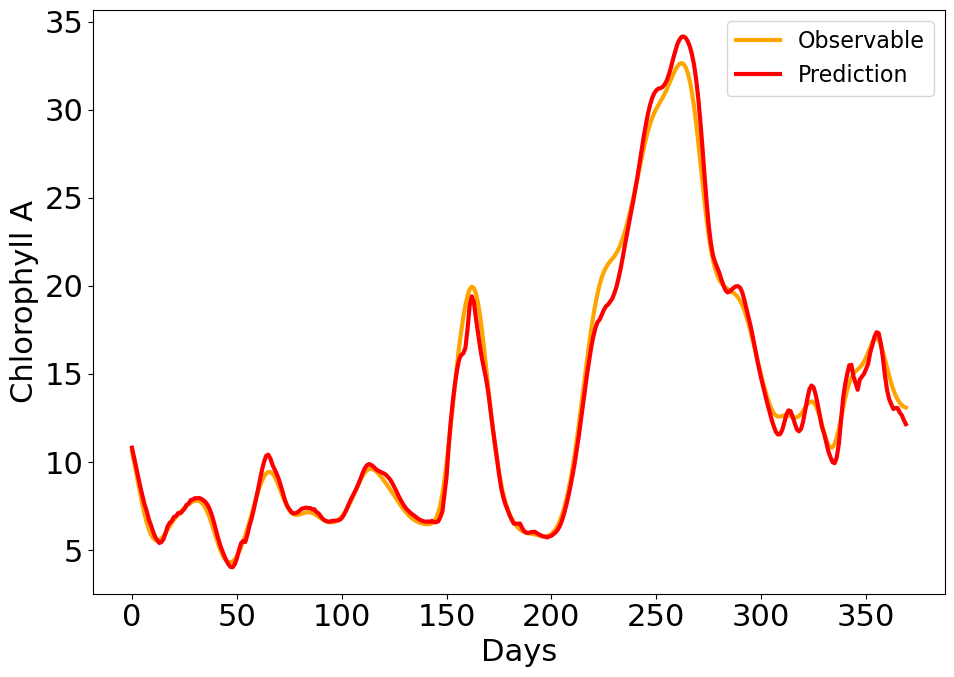

In [345]:

fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
Y_test_abs = np.array((Abs_test.unsqueeze(1) * out).tolist())[:,0]
Y_test_abs_exp = np.array((Abs_test.unsqueeze(1) * Y_test.unsqueeze(1)).tolist())[:,0]

ax = axd["gaussian"]
ax.plot(Y_test_abs_exp,label='Observable',color='orange')
ax.plot(Y_test_abs,label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest7reconst.png')

#

In [346]:
np.save('Exp7day',Y_test_abs_exp)
np.save('Pre7day',Y_test_abs)

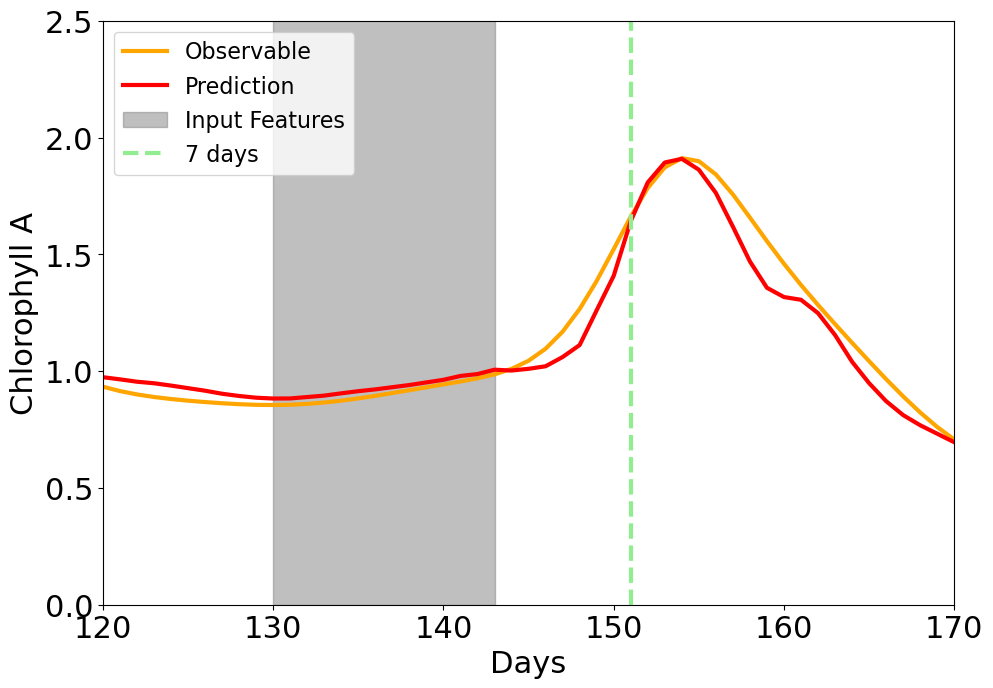

In [353]:
out, _ = model_2(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_xlim([120,170])
ax.set_ylim([0,2.5])
s = 130
ax.fill_between(range(s,s+14),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(s+21,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest7f.png')

#fig.savefig('TrainTestExample.png')

## Test 14 days

In [415]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-13):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+13] / chloro[i-1] ))
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [430]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[600:]
n_steps = 14
X, Y, Abs = [], [], []
for i in range(n_steps+1, len(chloro)-13):
    # X.append(chloro[i-n_steps:i])
    X.append(chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+13] / chloro[i-1] ))
    Abs.append(chloro[i-1])

Abs_test = torch.tensor(np.array(Abs), dtype=torch.float32,device='cuda')
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test= torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')


In [417]:
model_3 = LSTM_model_sig(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [418]:
model_3.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1**(1/500))
for i in range(500):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_3(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))
    scheduler.step()


0.9660616655213138
0.8862331601687603
0.8896143741698729
0.930010826430387
0.9460367541760206
0.8809426415504681
0.8870926422791349
0.877493497191204
0.8811573762860563
0.8821694728814893
0.8878745578436388
0.8863917980343103
0.8797206167752544
0.8816831651040249
0.8795190382127961
0.8784413449466228
0.9064367841929197
0.8895951005526714
0.9335450051973263
0.8775032644884454
0.880804736374153
0.8762343622123202
0.8817249084305432
0.8826168156746361
0.8847318694202436
0.8847106647574239
0.8753833524468873
0.8774168466528257
0.8821875517153077
0.8789645764562819
0.8789039796425236
0.8804022043736445
0.8808432337310579
0.8809465070565542
0.8806835774125324
0.8756888495344255
0.8820216721958585
0.8855086175931824
0.8814211813732982
0.8764187053052915
0.8834012540885143
0.877092231478956
0.8898767618876364
0.8791212118748162
0.8782077031210065
0.8794071402193772
0.8794671879667375
0.8814461711380217
0.8777486973752578
0.9374645626586344
0.8774251016891665
0.881584913469851
0.878827366667489

(-28.55, 599.55)

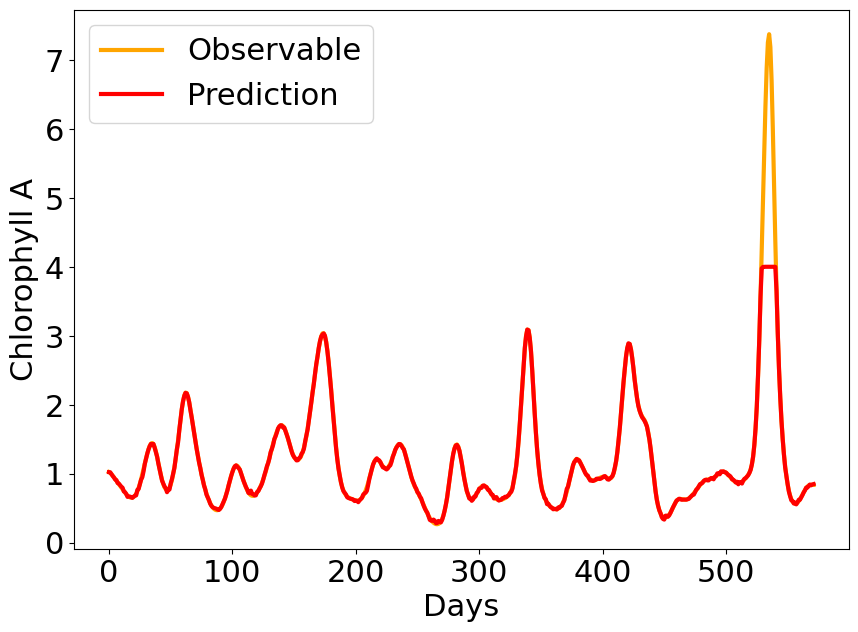

In [419]:
out, _ = model_3(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()
# fig.savefig('Plots/Reltrain14.png')

In [420]:
model_3(X_test.T.unsqueeze(2))

(tensor([[0.8025],
         [0.8374],
         [0.7824],
         [0.8253],
         [0.7560],
         [0.6094],
         [0.4888],
         [0.3855],
         [0.4128],
         [0.4476],
         [0.5352],
         [0.6641],
         [0.6874],
         [0.7155],
         [0.8836],
         [1.0421],
         [1.0832],
         [1.1560],
         [1.1806],
         [1.1863],
         [1.2071],
         [1.1676],
         [1.0951],
         [1.0693],
         [1.0252],
         [0.9853],
         [1.0384],
         [1.1192],
         [1.1879],
         [1.3040],
         [1.2176],
         [1.0682],
         [1.1253],
         [1.2373],
         [0.6941],
         [0.5879],
         [0.5334],
         [0.5377],
         [0.7409],
         [0.9038],
         [0.6458],
         [0.3852],
         [0.2876],
         [0.2496],
         [0.2343],
         [0.2835],
         [0.4385],
         [0.6553],
         [0.7493],
         [0.7800],
         [0.9381],
         [1.0618],
         [1.

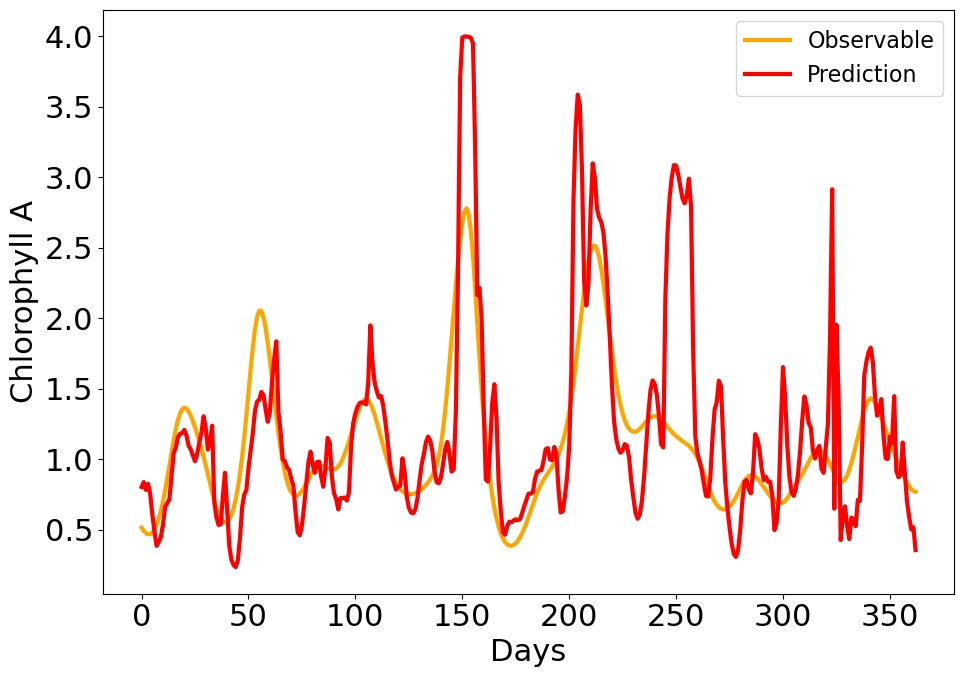

In [425]:
out, _ = model_3(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
# ax.set_xlim([130,180])
# ax.fill_between(range(139,153),0,15, alpha=0.5,color='grey',label='Input Features')
# ax.vlines(160,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest14.png')
#fig.savefig('TrainTestExample.png')

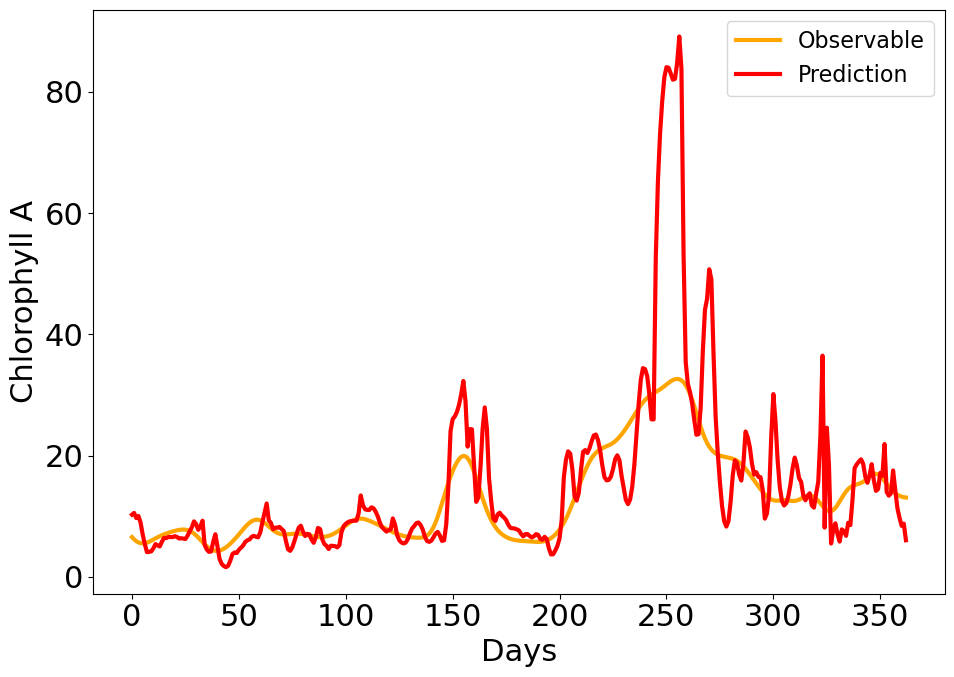

In [426]:
out, _ = model_3(X_test.T.unsqueeze(2))

fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
Y_test_abs = np.array((Abs_test.unsqueeze(1) * out).tolist())[:,0]
Y_test_abs_exp = np.array((Abs_test.unsqueeze(1) * Y_test.unsqueeze(1)).tolist())[:,0]

ax = axd["gaussian"]
ax.plot(Y_test_abs_exp,label='Observable',color='orange')
ax.plot(Y_test_abs,label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest14exabs.png')


In [423]:
np.save('Exp14day',Y_test_abs_exp)
np.save('Pre14day',Y_test_abs)

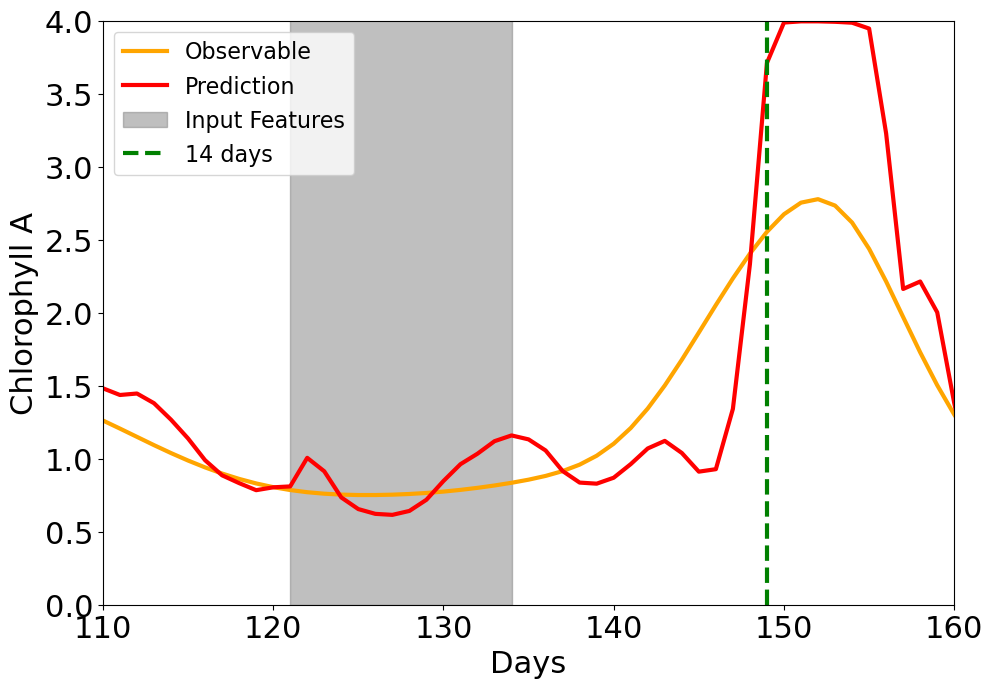

In [424]:
out, _ = model_3(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
t=110
ax.set_xlim([t,t+50])
ax.set_ylim([0,4])
s = 121
ax.fill_between(range(s,s+14),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(s+28,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest14f.png')
#fig.savefig('TrainTestExample.png')

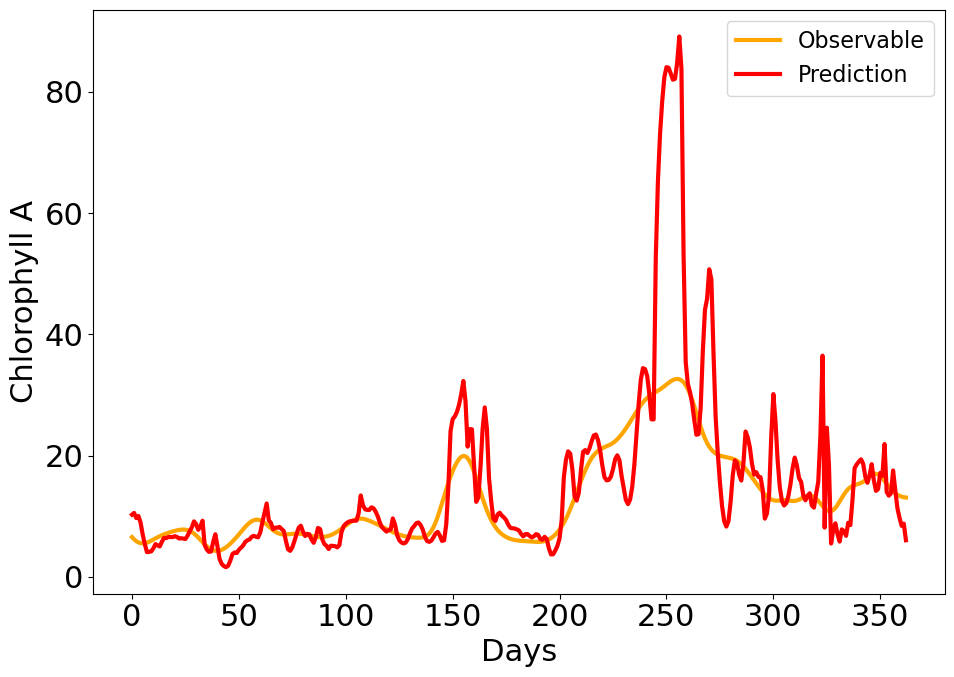

In [431]:
out, _ = model_3(X_test.T.unsqueeze(2))

fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
Y_test_abs = np.array((Abs_test.unsqueeze(1) * out).tolist())[:,0]
Y_test_abs_exp = np.array((Abs_test.unsqueeze(1) * Y_test.unsqueeze(1)).tolist())[:,0]

ax = axd["gaussian"]
ax.plot(Y_test_abs_exp,label='Observable',color='orange')
ax.plot(Y_test_abs,label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.legend(fontsize=16)

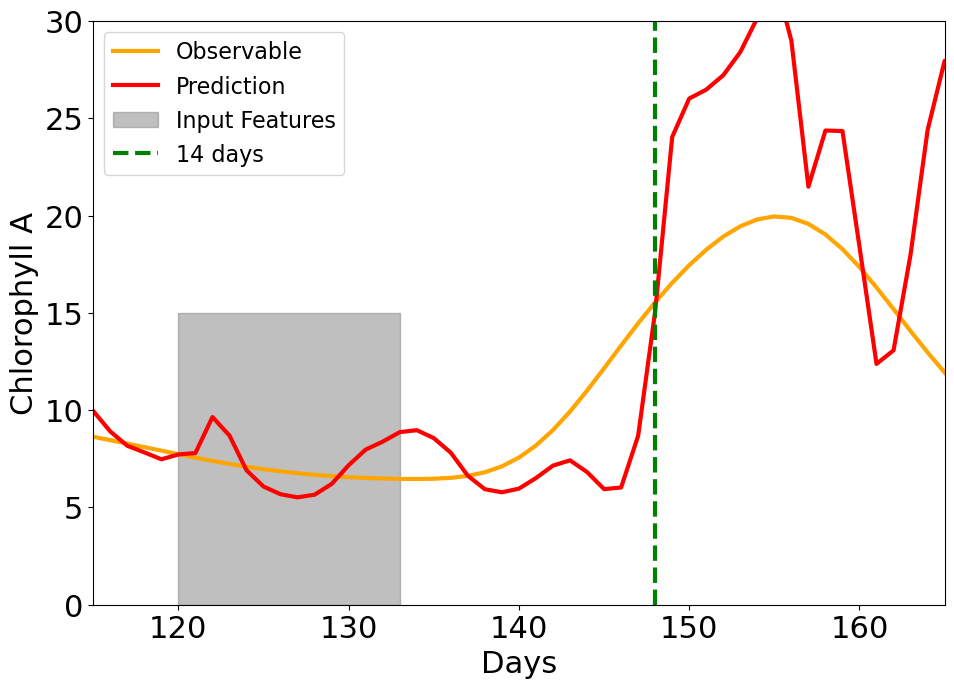

In [438]:
out, _ = model_3(X_test.T.unsqueeze(2))

fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
Y_test_abs = np.array((Abs_test.unsqueeze(1) * out).tolist())[:,0]
Y_test_abs_exp = np.array((Abs_test.unsqueeze(1) * Y_test.unsqueeze(1)).tolist())[:,0]

ax = axd["gaussian"]
ax.plot(Y_test_abs_exp,label='Observable',color='orange')
ax.plot(Y_test_abs,label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.legend(fontsize=16)
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
t=115
ax.set_xlim([t,t+50])
ax.set_ylim([0,30])
s = 120
ax.fill_between(range(s,s+14),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(s+28,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/relAbstest14f.png')

In [233]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-20):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+20] / chloro[i-1] ))
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

chloro = gaussian_filter1d(day_df['z6'].values,4)[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-20):
    # X.append(chloro[i-n_steps:i])
    X.append(chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+20] / chloro[i-1] ))
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test= torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [209]:
model_4 = LSTM_model_sig(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

In [210]:
model_4.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1**(1/500))
for i in range(500):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_4(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))
    scheduler.step()

1.3659321745516548
1.2823938519602092
1.2849020210789963
1.296664145211099
1.2832524509916843
1.2890110083029305
1.2830273962356675
1.284917939506786
1.2846400811218879
1.2837632923898563
1.312287775563522
1.292443607264841
1.2825619739965655
1.2824314379356276
1.3014473176338304
1.2826168318869362
1.2849912844913107
1.2830824039771522
1.2942544710887989
1.2810626605027158
1.2818726945511052
1.302038976843928
1.2823963026765366
1.288959522902126
1.285465471551452
1.285247972733538
1.2880085005726614
1.2947357523609215
1.2832349985837936
1.2942912878704742
1.2878401334017096
1.2832222988068218
1.2851418676510664
1.288924439902037
1.280024711724738
1.280566413217867
1.2815371743390258
1.2812298420869128
1.3060767617024167
1.289374137848196
1.2800307846824888
1.2798352212133541
1.300782442302771
1.2841224513003524
1.2875573251029135
1.2819958948333499
1.2817388512718846
1.283563630891518
1.2865607948370383
1.2874104221102218
1.2816648403523674
1.2887573838233948
1.2934566565172774
1.28229

In [ ]:
/localhome/kpaul/DSTSES_DataLakes/Plots


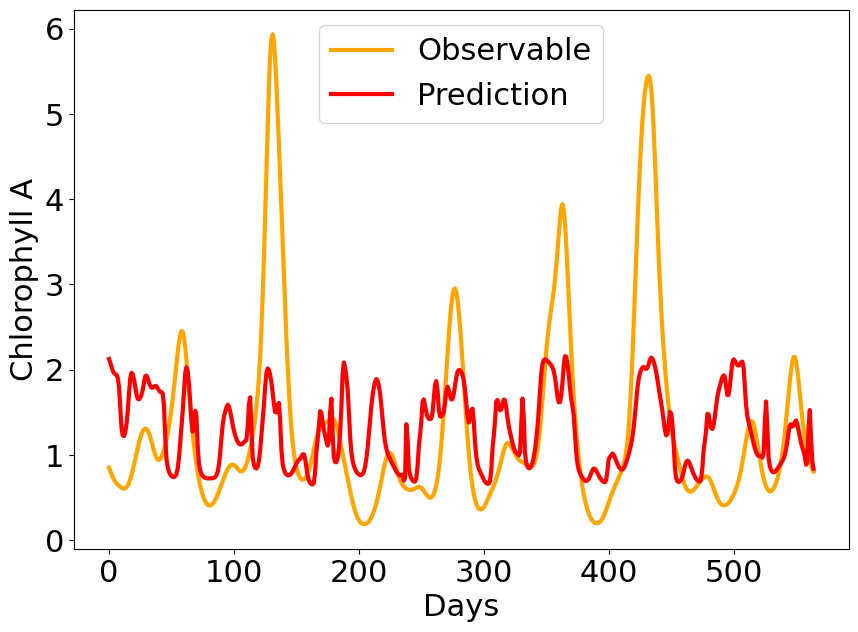

In [234]:
out, _ = model_4(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()
fig.savefig('Plots/Reltrain21.png')

In [238]:
#torch.save(model_4,'model4.pt')